In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from time import sleep
from IPython.display import clear_output
from collections import namedtuple, deque

from unityagents import UnityEnvironment

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

In [3]:
from noise import OUNoise
from buffer import ReplayBuffer
from ddpg_model import PolicyNetwork, ValueNetwork

In [4]:
import warnings
warnings.simplefilter('ignore', UserWarning)

In [5]:
plt.style.use('ggplot')

## Set Configs

In [6]:
is_cuda = torch.cuda.is_available()

if is_cuda: device = torch.device('cuda')
else: device = torch.device('cpu')

In [7]:
BUFFER_SIZE = int(1e6)
BATCH_SIZE = 512
GAMMA = 0.99
TAU = 1e-3
PRINT_EVERY = 100
UPDATE_EVERY = 4

# actor & critic network have different learning rates
LR_ACTOR = 1e-4
LR_CRITIC = 3e-4
WEIGHT_DECAY = 0 # L2 weight decay

## Set Environment

In [8]:
env = UnityEnvironment(file_name='./Reacher_1_Agent/Reacher.x86_64')

brain_name = env.brain_names[0] # get the brain from unity environment
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [9]:
print('Environment Info')
env_info = env.reset(train_mode=False)[brain_name] # reset environment to a new, random state
state = env_info.vector_observations
action_size = brain.vector_action_space_size

print('Number of agents: {}'.format(len(env_info.agents)))
print('State space: {}'.format(state.shape[1]))
print('Action space: {}'.format(action_size))

Environment Info
Number of agents: 1
State space: 33
Action space: 4


## Define [DDPG](https://arxiv.org/pdf/1509.02971.pdf) Agent

In [10]:
class DDPGAgent():
    """The Agent that will interacts with and learns from the environment."""
    
    def __init__(self, env, brain_name, seed):
        """Initialize an Agent object."""
        
        self.brain = env.brains[env.brain_names[0]] # get the brain from unity environment
        
        self.env_info = env.reset(train_mode=False)[brain_name]
        
        self.state_size = env_info.vector_observations.shape[1]
        self.action_size = self.brain.vector_action_space_size
        
        self.gamma = GAMMA
        self.lr_actor = LR_ACTOR
        self.lr_critic = LR_CRITIC
        self.weight_decay = WEIGHT_DECAY
        self.tau = TAU
        
        # initialize actor and critic networks
        self.actor = PolicyNetwork(self.state_size, self.action_size, seed).to(device)
        self.actor_target = PolicyNetwork(self.state_size, self.action_size, seed).to(device)
        
        self.critic = ValueNetwork(self.state_size, self.action_size, seed).to(device)
        self.critic_target = ValueNetwork(self.state_size, self.action_size, seed).to(device)
            
        # set optimizers
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=self.lr_actor)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=self.lr_critic, weight_decay=self.weight_decay)
        
        # initialize actor & critic target networks
        self.soft_update(self.actor, self.actor_target, 1)
        self.soft_update(self.critic, self.critic_target, 1)
        
        # introduce noise process
        self.noise = OUNoise(self.action_size, seed)
        
        # set buffer
        self.buffer = ReplayBuffer(BUFFER_SIZE, BATCH_SIZE, seed)
        self.time_step = 0
        
    def memorize(self, states, actions, rewards, next_states, dones):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        
        for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
            self.buffer.add(state, action, reward, next_state, done)
        
        # learn every UPDATE_EVERY time steps
        self.time_step = (self.time_step + 1) % UPDATE_EVERY
        
        if self.time_step == 0:
            # if enough samples are available in memory, get random subset and learn
            if len(self.buffer) > BATCH_SIZE:
                experiences = self.buffer.sample()
                self.learn(experiences, self.gamma)
    
    def act(self, states, add_noise=True):
        """Return action for given state as per current policy."""
        
        states = torch.FloatTensor(states).to(device)
        self.actor.eval()
        with torch.no_grad():
            actions = self.actor(states).cpu().data.numpy()
        self.actor.train()
        
        if add_noise==True:
            actions += self.noise.sample()
        
        actions = np.clip(actions, -1, 1)
        
        return actions
    
    def reset(self):
        """Reset noise parameters."""
        self.noise.reset()
        
    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples."""
        
        states, actions, rewards, next_states, dones = experiences
        
        # obtain Q expected
        Q_expected = self.critic(states, actions)
        
        next_actions = self.actor_target(next_states)
        Q_target_next = self.critic_target(next_states, next_actions)
        
        # compute Q target
        Q_targets = rewards + (gamma * Q_target_next * (1 - dones))
        
        # compute value loss
        value_loss = F.mse_loss(Q_expected, Q_targets)
        
        # minimize critic loss
        self.critic_optimizer.zero_grad()
        value_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic.parameters(), 1)
        self.critic_optimizer.step()
        
        # update actor
        policy_loss = -self.critic(states, self.actor(states)).mean()
        
        # minimize policy loss
        self.actor_optimizer.zero_grad()
        policy_loss.backward()
        self.actor_optimizer.step()
        
        # softly update target networks
        self.soft_update(self.actor, self.actor_target, self.tau)
        self.soft_update(self.critic, self.critic_target, self.tau)
    
    def soft_update(self, local_model, target_model, tau):
        """Softly update model parameters."""
        
        for local_param, target_param in zip(local_model.parameters(), target_model.parameters()):
            target_param.data.copy_(local_param.data * tau + target_param.data * (1.0 - tau))
            
    def save(self, actor_path, critic_path):
        """Save trained agent."""
        if not os.path.exists('./agents/'): os.makedirs('./agents/')
        torch.save(agent.actor.state_dict(), actor_path); torch.save(agent.critic.state_dict(), critic_path)
    
    def load(self, agent_location):
        """Load trained agent."""
        self.actor.load_state_dict(torch.load(agent_location))
        
    def watch(self, num_episodes, max_time):
        """Watch trained agent."""
        
        all_scores = []

        for i_episode in range(1, num_episodes+1):

            self.reset()
            env_info = env.reset(train_mode=False)[brain_name]
            states = env_info.vector_observations
            scores = np.zeros(len(env_info.agents))
            
            for time_step in range(max_time):

                actions = agent.act(states, add_noise=True)
                env_info = env.step(actions)[brain_name]
                next_states, rewards, dones = env_info.vector_observations, env_info.rewards, env_info.local_done
            
                states = next_states
                scores += rewards

            avg_score = np.mean(scores)
            all_scores.append(avg_score)
            print(f'\rEpisode: {i_episode}, Average Score: {avg_score:.2f}')

        env.close()
        print(f'Total score for {num_episodes} episodes: {np.mean(all_scores):.2f}')
        print('Watching finished.')

In [11]:
agent = DDPGAgent(env, brain_name, seed=90)

## Train The Agent

In [12]:
def train_agent(num_episodes=1500, max_time=2000):
    """Train DQN agent."""
    
    all_scores = []
    scores_target = 60.0
    scores_window = deque(maxlen=PRINT_EVERY)
    
    for i_episode in range(1, num_episodes+1):
        
        agent.reset()
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        scores = np.zeros(len(env_info.agents))
        
        for time_step in range(max_time):
            
            actions = agent.act(states, add_noise=True)
            env_info = env.step(actions)[brain_name]
            next_states, rewards, dones = env_info.vector_observations, env_info.rewards, env_info.local_done
            
            agent.memorize(states, actions, rewards, next_states, dones)
            states = next_states
            scores += rewards
            
        avg_score = np.mean(scores)
        scores_window.append(avg_score)
        all_scores.append(avg_score)
        
        print(f'\rEpisode: {i_episode}, Average Score: {np.mean(scores_window):.2f}', end='')
        
        if i_episode % PRINT_EVERY == 0:
            print(f'\rEpisode: {i_episode}, Average Score: {np.mean(scores_window):.2f}')
        if np.mean(scores_window) >= scores_target:
            print(f'\nEnvironment solved in {i_episode-100:d} episodes! Average Score: {np.mean(scores_window):.2f}')
            if not os.path.exists('./agents/'): os.makedirs('./agents/')
            agent.save(f'./agents/ACTOR_{brain_name}.pth', f'./agents/CRITIC_{brain_name}.pth')
            break
            
    print('Training completed.')
    return all_scores

In [13]:
all_scores = train_agent(num_episodes=1500, max_time=2000)

Episode: 100, Average Score: 5.84
Episode: 200, Average Score: 30.87
Episode: 300, Average Score: 34.71
Episode: 400, Average Score: 45.38
Episode: 500, Average Score: 52.85
Episode: 600, Average Score: 51.80
Episode: 700, Average Score: 54.13
Episode: 800, Average Score: 50.73
Episode: 900, Average Score: 50.39
Episode: 1000, Average Score: 42.17
Episode: 1100, Average Score: 38.79
Episode: 1200, Average Score: 38.81
Episode: 1300, Average Score: 43.94
Episode: 1400, Average Score: 39.85
Episode: 1500, Average Score: 32.84
Training completed.


## Evaluate The Agent

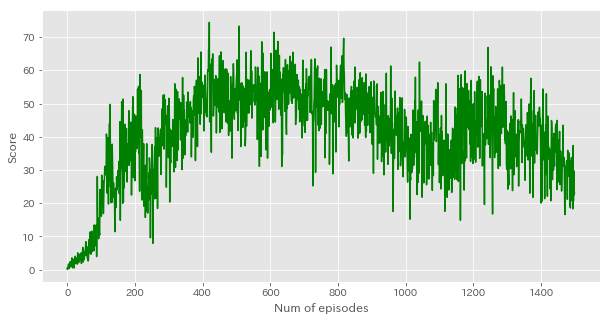

In [14]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(len(all_scores)), all_scores, color='green')
plt.xlabel('Num of episodes')
plt.ylabel('Score')
if not os.path.exists('./images/'): os.makedirs('./images/')
plt.savefig('./images/plot_of_ddpg_evaluation.png')
plt.show()

## 🎬 Watch The Agent

In [15]:
agent.load(f'./agents/ACTOR_{brain_name}.pth')

In [16]:
agent.watch(num_episodes=10, max_time=1000)

Episode: 1, Average Score: 11.85
Episode: 2, Average Score: 14.69
Episode: 3, Average Score: 33.26
Episode: 5, Average Score: 19.77
Episode: 6, Average Score: 11.28
Episode: 7, Average Score: 14.07
Episode: 8, Average Score: 10.08
Episode: 9, Average Score: 7.24
Episode: 10, Average Score: 22.63
Total score for 10 episodes: 16.21
Watching finished.


---